In [1]:
# Import the required libraries
import os
import pickle
import numpy as np
import pandas as pd
from statistics import mode
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        # Initialize Multinomial Naive Bayes with alpha Laplace smoothing parameter
        self.alpha = alpha
        self.class_log_prior_ = None  # Placeholder for class log priors
        self.feature_log_prob_ = None  # Placeholder for feature log probabilities
        self.classes_ = None  # Placeholder for unique classes

    def fit(self, X, y):
        # Fit the Multinomial Naive Bayes model to the training data X and labels y
        n_samples, n_features = X.shape  # Get the number of samples and features
        self.classes_ = np.unique(y)  # Get the unique classes from the labels

        n_classes = self.classes_.shape[0]  # Number of unique classes
        self.class_log_prior_ = np.zeros(n_classes)  # Initialize class log priors array
        self.feature_log_prob_ = np.zeros((n_classes, n_features))  # Initialize feature log probabilities array

        for i, c in enumerate(self.classes_):
            # Iterate over each class
            X_c = X[y == c]  # Select samples belonging to class c
            self.class_log_prior_[i] = np.log((X_c.shape[0] + self.alpha) / (n_samples + self.alpha * n_classes))
            # Compute class log prior
            self.feature_log_prob_[i] = np.log((np.sum(X_c, axis=0) + self.alpha) / (np.sum(X_c) + self.alpha * n_features))
            # Compute feature log probabilities

    def predict_class_probabilities(self, X):
        # Predict class probabilities for input data X
        return safe_sparse_dot(X, self.feature_log_prob_.T) + self.class_log_prior_

    def predict(self, X):
        # Predict class labels for input data X
        return self.classes_[np.argmax(self.predict_class_probabilities(X), axis=1)]


In [3]:
seed = 87

In [4]:
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv('dataset.csv', encoding='iso-8859-1')
data = df.where((pd.notnull(df)), '')

data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [6]:
# Extracting features (X) and target variable (y)
X = data['text']  # Features (email content)
y = data['label']  # Target variable (spam or not spam)

# Display the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (83448,)
Shape of y: (83448,)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
data.groupby('label').describe()

text                                                               
       count unique                                                top freq
label                                                                      
0      39538  39538   computer connection from cnn com wednesday es...    1
1      43910  43910  ounce feather bowl hummingbird opec moment ala...    1

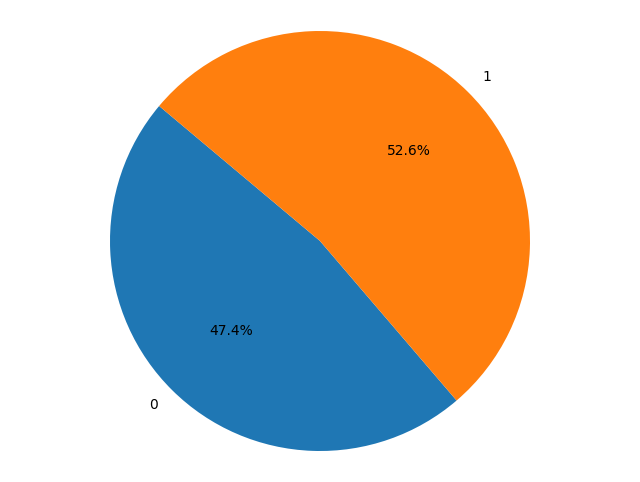

In [9]:
# Extracting counts of each label category
label_counts = data.groupby('label').size()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title('Distribution of Labels')

plt.savefig('plots/data.pdf')
plt.show()

In [10]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=seed)

# Display the shape of X and y
print("Shape of X_train (Unvectorized):", X_train_raw.shape)
print("Shape of y_train:", y_train_raw.shape)

print("\nShape of X_test (Unvectorized):", X_test_raw.shape)
print("Shape of y_test:", y_test_raw.shape)

Shape of X_train (Unvectorized): (66758,)
Shape of y_train: (66758,)

Shape of X_test (Unvectorized): (16690,)
Shape of y_test: (16690,)


In [11]:
X_train_raw.describe()

count                                                 66758
unique                                                66758
top       here is the updated version of the netco headc...
freq                                                      1
Name: text, dtype: object

In [12]:
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)

X_train = feature_extraction.fit_transform(X_train_raw)
X_test = feature_extraction.transform(X_test_raw)

y_train = y_train_raw.astype('int')
y_test = y_test_raw.astype('int')

# Display the shape of X and y
print("Shape of X_train (Vectorized):", X_train.shape)
print("Shape of y_train:", y_train_raw.shape)

print("\nShape of X_test (Vectorized):", X_test.shape)
print("Shape of y_test:", y_test_raw.shape)

with open('models/feature_extraction.pkl', 'wb') as file:
    pickle.dump(feature_extraction, file)

Shape of X_train (Vectorized): (66758, 261147)
Shape of y_train: (66758,)

Shape of X_test (Vectorized): (16690, 261147)
Shape of y_test: (16690,)


#### Naive Bayes

--------------------------------------------------------
Classification_Report (Training): 
               precision    recall  f1-score   support

           0     0.9745    0.9890    0.9817     31702
           1     0.9899    0.9766    0.9832     35056

    accuracy                         0.9825     66758
   macro avg     0.9822    0.9828    0.9824     66758
weighted avg     0.9826    0.9825    0.9825     66758



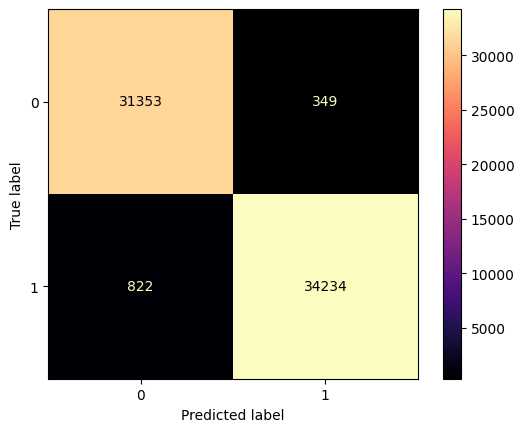

--------------------------------------------------------
Classification_Report (Test): 
               precision    recall  f1-score   support

           0     0.9598    0.9890    0.9742      7836
           1     0.9900    0.9633    0.9765      8854

    accuracy                         0.9754     16690
   macro avg     0.9749    0.9762    0.9753     16690
weighted avg     0.9758    0.9754    0.9754     16690



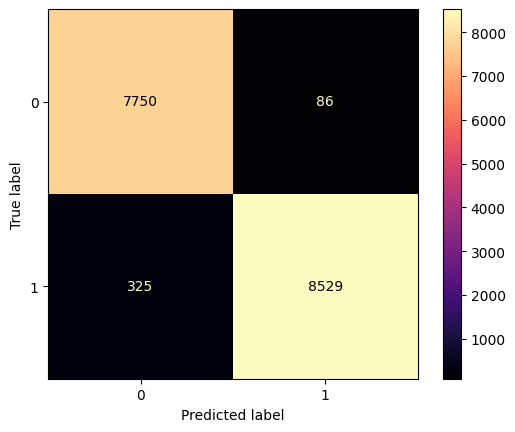

In [13]:
model_nb = MultinomialNaiveBayes() # Defined above
model_nb.fit(X_train, y_train)

model_nb_data = {
    'alpha': model_nb.alpha,
    'class_log_prior_': model_nb.class_log_prior_,
    'feature_log_prob_': model_nb.feature_log_prob_,
    'classes_': model_nb.classes_
}

with open('models/multinomial_nb.pkl', 'wb') as file:
    pickle.dump(model_nb_data, file)

train_prediction_nb = model_nb.predict(X_train)
print('\033[1m--------------------------------------------------------\033[0m')
print("Classification_Report (Training): \n",classification_report(y_train, train_prediction_nb, digits=4))

train_cm_nb = confusion_matrix(y_train, train_prediction_nb)
train_disp_nb = ConfusionMatrixDisplay(confusion_matrix=train_cm_nb)
train_disp_nb.plot(cmap='magma')
# plt.title('Confusion Matrix (Train)')
plt.savefig('plots/train_cm_nb.pdf')
plt.show()

test_prediction = model_nb.predict(X_test)
print('\033[1m--------------------------------------------------------\033[0m')
print("Classification_Report (Test): \n",classification_report(y_test, test_prediction, digits=4))

test_cm_nb = confusion_matrix(y_test, test_prediction)
test_disp_nb = ConfusionMatrixDisplay(confusion_matrix=test_cm_nb)
test_disp_nb.plot(cmap='magma')
# plt.title('Confusion Matrix (Test)')
plt.savefig('plots/test_cm_nb.pdf')
plt.show()

#### SVM (Linear Kernel)

--------------------------------------------------------
Classification_Report (Training): 
               precision    recall  f1-score   support

           0     0.9988    0.9951    0.9970     31702
           1     0.9956    0.9989    0.9973     35056

    accuracy                         0.9971     66758
   macro avg     0.9972    0.9970    0.9971     66758
weighted avg     0.9971    0.9971    0.9971     66758



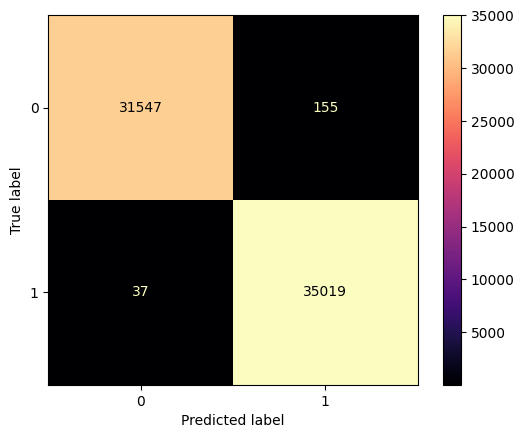

--------------------------------------------------------
Classification_Report (Test): 
               precision    recall  f1-score   support

           0     0.9941    0.9877    0.9909      7836
           1     0.9892    0.9948    0.9920      8854

    accuracy                         0.9915     16690
   macro avg     0.9917    0.9913    0.9915     16690
weighted avg     0.9915    0.9915    0.9915     16690



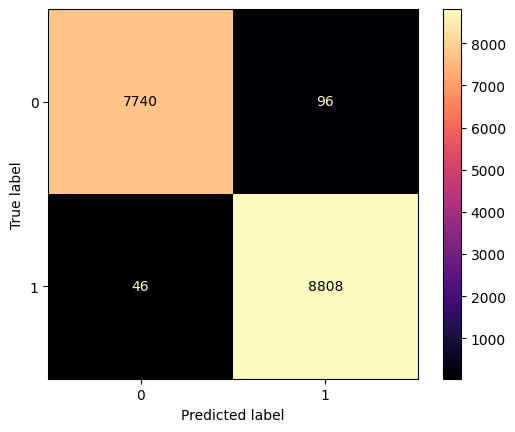

In [14]:
model_svm_linear = SVC(kernel='linear', random_state=seed)
model_svm_linear.fit(X_train, y_train)

with open('models/svm_linear.pkl', 'wb') as file:
    pickle.dump(model_svm_linear, file)

train_prediction_svm_linear = model_svm_linear.predict(X_train)
print('\033[1m--------------------------------------------------------\033[0m')
print("Classification_Report (Training): \n",classification_report(y_train, train_prediction_svm_linear, digits=4))

train_cm_svm_linear = confusion_matrix(y_train, train_prediction_svm_linear)
train_disp_svm_linear = ConfusionMatrixDisplay(confusion_matrix=train_cm_svm_linear)
train_disp_svm_linear.plot(cmap='magma')
# plt.title('Confusion Matrix (Train)')
plt.savefig('plots/train_cm_svm_linear.pdf')
plt.show()

test_prediction_svm_linear = model_svm_linear.predict(X_test)
print('\033[1m--------------------------------------------------------\033[0m')
print("Classification_Report (Test): \n",classification_report(y_test, test_prediction_svm_linear, digits=4))

test_cm_svm_linear = confusion_matrix(y_test, test_prediction_svm_linear)
test_disp_svm_linear = ConfusionMatrixDisplay(confusion_matrix=test_cm_svm_linear)
test_disp_svm_linear.plot(cmap='magma')
# plt.title('Confusion Matrix (Test)')
plt.savefig('plots/test_cm_svm_linear.pdf')
plt.show()

#### SVM (RBF Kernel)

In [15]:
model_svm_rbf = SVC(kernel='rbf', random_state=seed)
model_svm_rbf.fit(X_train, y_train)

with open('models/svm_rbf.pkl', 'wb') as file:
    pickle.dump(model_svm_rbf, file)

train_prediction_svm_rbf = model_svm_rbf.predict(X_train)
print('\033[1m--------------------------------------------------------\033[0m')
print("Classification_Report (Training): \n",classification_report(y_train, train_prediction_svm_rbf, digits=4))

train_cm_svm_rbf = confusion_matrix(y_train, train_prediction_svm_rbf)
train_disp_svm_rbf = ConfusionMatrixDisplay(confusion_matrix=train_cm_svm_rbf)
train_disp_svm_rbf.plot(cmap='magma')
# plt.title('Confusion Matrix (Train)')
plt.savefig('plots/train_cm_svm_rbf.pdf')
plt.show()

test_prediction_svm_rbf = model_svm_rbf.predict(X_test)
print('\033[1m--------------------------------------------------------\033[0m')
print("Classification_Report (Test): \n",classification_report(y_test, test_prediction_svm_rbf, digits=4))

test_cm_svm_rbf = confusion_matrix(y_test, test_prediction_svm_rbf)
test_disp_svm_rbf = ConfusionMatrixDisplay(confusion_matrix=test_cm_svm_rbf)
test_disp_svm_rbf.plot(cmap='magma')
# plt.title('Confusion Matrix (Test)')
plt.savefig('plots/test_cm_svm_rbf.pdf')
plt.show()